In [6]:
# Import libraries
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load dataset
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

# Features and labels
X_train = train_df["transcription"]
y_train = train_df["medical_specialty"]

X_val = val_df["transcription"]
y_val = val_df["medical_specialty"]

X_test = test_df["transcription"]
y_test = test_df["medical_specialty"]


Repo card metadata block was not found. Setting CardData to empty.


In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

In [10]:
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)

In [11]:
cv_scores = cross_val_score(log_reg, X_train_vec, y_train, cv=5, scoring="accuracy")
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in ver

Cross-validation Accuracy Scores: [0.77971014 0.75942029 0.74202899 0.75362319 0.75290698]
Mean CV Accuracy: 0.7575379170879677


In [12]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "saga"]
}

grid = GridSearchCV(
    LogisticRegression(multi_class="multinomial", max_iter=1000),
    param_grid,
    cv=5,
    scoring="f1_weighted"
)

grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in ver

Best Parameters: {'C': 10, 'solver': 'saga'}
Best Cross-Validation Score: 0.7745608279460761


In [13]:
best_model = grid.best_estimator_
best_model.fit(X_train_vec, y_train)


C:\Users\Menuki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'multinomial'


In [12]:
y_pred_val = best_model.predict(X_val_vec)

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred_val))


Classification Report (Validation):
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.89      0.95      0.92       107
      ENT - Otolaryngology       1.00      0.62      0.76        13
          Gastroenterology       0.88      0.79      0.84        29
     Hematology - Oncology       0.72      0.68      0.70        19
                Nephrology       0.91      0.62      0.74        16
                 Neurology       0.64      0.56      0.60        48
              Neurosurgery       0.27      0.31      0.29        13
   Obstetrics / Gynecology       0.92      0.96      0.94        24
             Ophthalmology       1.00      0.90      0.95        10
                Orthopedic       0.70      0.81      0.75        62
     Pediatrics - Neonatal       0.62      1.00      0.77        10
   Psychiatry / Psychology       0.80      0.80      0.80        10
                 Radiology       0.20      0.11      0.14         9

         

In [13]:
y_pred_test = best_model.predict(X_test_vec)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))


Classification Report (Test):
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.93      0.96      0.95       109
      ENT - Otolaryngology       1.00      0.64      0.78        14
          Gastroenterology       0.92      0.88      0.90        41
     Hematology - Oncology       0.50      0.67      0.57        15
                Nephrology       1.00      0.60      0.75        10
                 Neurology       0.62      0.64      0.63        47
              Neurosurgery       0.40      0.40      0.40        20
   Obstetrics / Gynecology       0.96      0.72      0.82        32
             Ophthalmology       0.80      0.73      0.76        11
                Orthopedic       0.71      0.74      0.72        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0.67      0.71         9
                 Radiology       0.00      0.00      0.00         2

               

In [14]:
joblib.dump(best_model, "softmax_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

print("✅ Model and Vectorizer saved successfully!")

✅ Model and Vectorizer saved successfully!


In [2]:
def evaluate_metrics(y_true, y_pred, dataset_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    
    print(f"\n📊 Metrics for {dataset_name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")


In [3]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=sorted(set(y_true)), 
                yticklabels=sorted(set(y_true)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [4]:
def analyze_class_performance(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    results_df = pd.DataFrame(report).transpose()
    results_df = results_df.drop(["accuracy", "macro avg", "weighted avg"])
    sorted_df = results_df.sort_values("f1-score", ascending=False)
    
    print("\n🔹 Strongest Specialties (Top 3 by F1-score):")
    print(sorted_df.head(3)[["precision", "recall", "f1-score"]])
    print("\n🔻 Weakest Specialties (Bottom 3 by F1-score):")
    print(sorted_df.tail(3)[["precision", "recall", "f1-score"]])
    
    return sorted_df



📊 Metrics for Validation Set:
Accuracy:  0.7784
Precision: 0.7805
Recall:    0.7784
F1-score:  0.7736


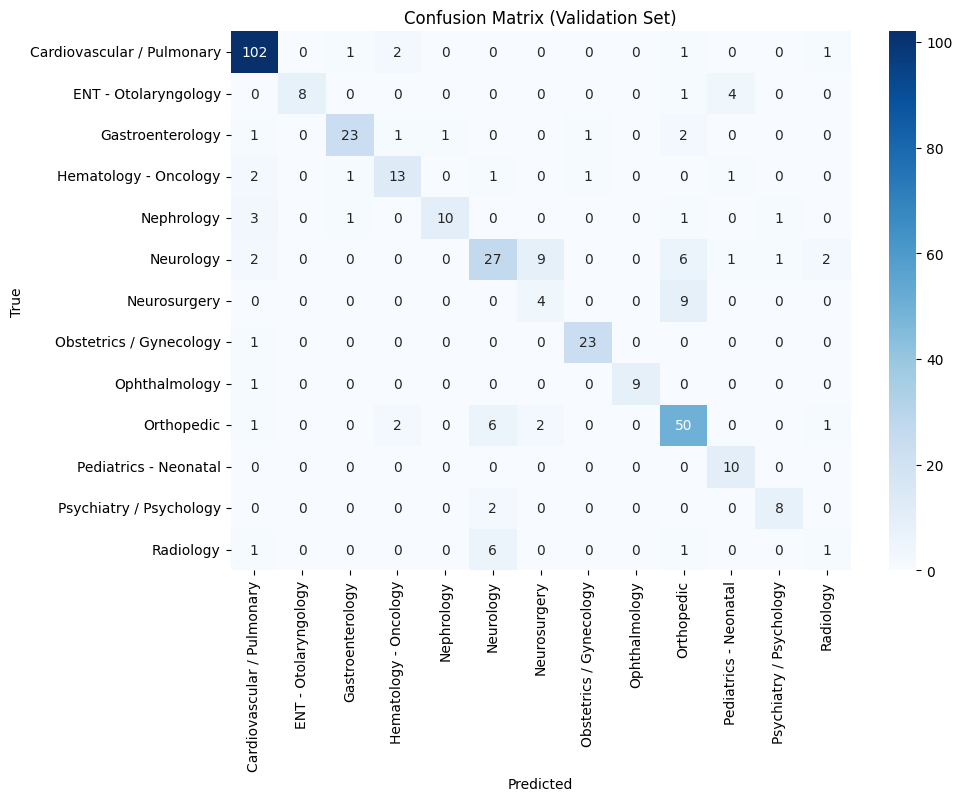


🔹 Strongest Specialties (Top 3 by F1-score):
                            precision    recall  f1-score
Ophthalmology                1.000000  0.900000  0.947368
Obstetrics / Gynecology      0.920000  0.958333  0.938776
Cardiovascular / Pulmonary   0.894737  0.953271  0.923077

🔻 Weakest Specialties (Bottom 3 by F1-score):
              precision    recall  f1-score
Neurology      0.642857  0.562500  0.600000
Neurosurgery   0.266667  0.307692  0.285714
Radiology      0.200000  0.111111  0.142857


In [14]:
y_pred_val = best_model.predict(X_val_vec)

evaluate_metrics(y_val, y_pred_val, "Validation Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix (Validation Set)")
results_val = analyze_class_performance(y_val, y_pred_val, sorted(set(y_train)))